# Analyse Results

Average = macro

Precision = 0.74
Recall = 0.64
F1 = 0.62
              precision    recall  f1-score   support

         FUN       0.70      0.88      0.78       412
         STR       0.79      0.87      0.83       535
         MIX       0.69      0.06      0.11       176
         OTH       0.78      0.75      0.77        77

    accuracy                           0.75      1200
   macro avg       0.74      0.64      0.62      1200
weighted avg       0.74      0.75      0.70      1200



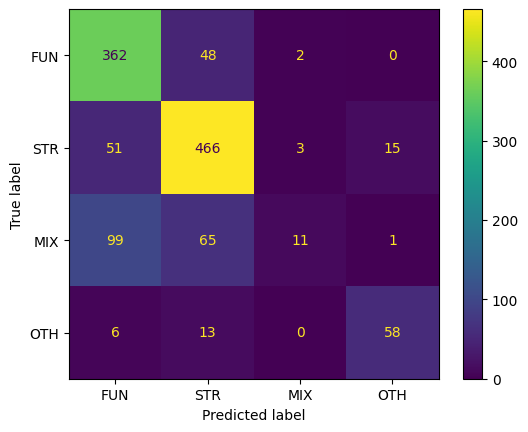

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import json
import ast
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')


# Set file to analyse
file_name = "test_10_3"

# Import data
file_path = f"/home/fantoni/patent-sentence-classification/results/incremental/{file_name}.xlsx"
result_df = pd.read_excel(file_path)

# Set labels
display_labels = ['FUN', 'STR', 'MIX', 'OTH']
true_labels = result_df['sent_tag']  
predicted_labels = result_df['predicted_tag']

# Calculate classification metrics
average = 'macro'
precision = precision_score(true_labels, predicted_labels, average=average, zero_division=0)
recall = recall_score(true_labels, predicted_labels, average=average, zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average=average, zero_division=0)
print(f'Average = {average}\n')
print(f'Precision = {precision:.2f}')  
print(f'Recall = {recall:.2f}')  
print(f'F1 = {f1:.2f}') 

# Create Classification Report
class_report = classification_report(true_labels, predicted_labels, labels=display_labels, target_names=display_labels, zero_division=0)
print (class_report)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=display_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot()
plt.show()

# Compare Incremental

In [13]:
import os
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

folder_path = "/home/fantoni/patent-sentence-classification/results/incremental"
id2num = {'1': 480, '2': 960, '3': 1440, '4': 1920, '5': 2400, '6': 2880, '7': 3360, '8': 3840, '9': 4320, '10': 4800}

# Set averaging mode
average = 'weighted'

results_all = []
for file_name in os.listdir(folder_path):
    if file_name.endswith(".xlsx"):
        sample_id = file_name.split('_')[1]
        #fold = file_name.split('_')[2].replace(".xlsx", "")
        df = pd.read_excel(os.path.join(folder_path, file_name))
        true_labels = df['sent_tag']  
        predicted_labels = df['predicted_tag']

    
    metrics = {
        'Sample Size': id2num[sample_id],
        'Precision': round(precision_score(true_labels, predicted_labels, average=average, zero_division=0), 3),
        'Recall': round(recall_score(true_labels, predicted_labels, average=average, zero_division=0), 3),
        'F1-Score': round(f1_score(true_labels, predicted_labels, average=average, zero_division=0), 3)
    }
    results_all.append(metrics)

results_df = pd.DataFrame(results_all).sort_values(by='Sample Size')
results_df

,Sample Size,Precision,Recall,F1-Score
0,480,0.524,0.582,0.519
45,480,0.551,0.582,0.538
46,480,0.527,0.588,0.541
63,480,0.550,0.629,0.566
64,480,0.611,0.634,0.584
...,...,...,...,...
94,4800,0.736,0.747,0.697
95,4800,0.754,0.757,0.719
96,4800,0.757,0.762,0.735
97,4800,0.759,0.765,0.744


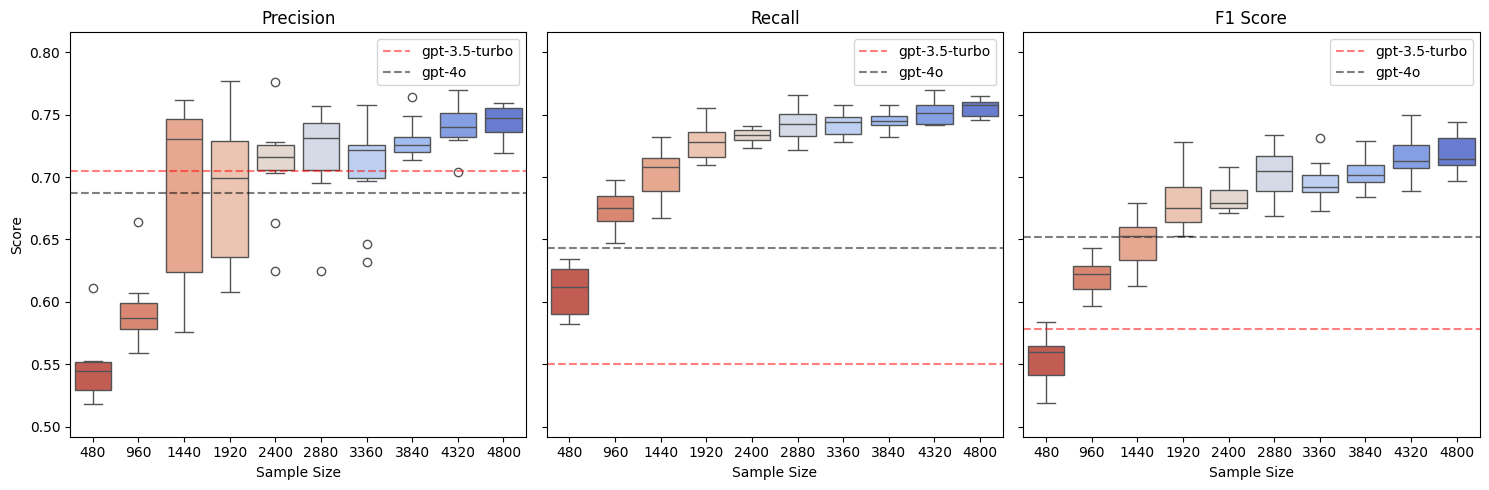

In [15]:
# Create the Box Plot Chart

# Define the y-axis limits
y_min = min(results_df["Precision"].min(), results_df["Recall"].min(), results_df["F1-Score"].min()) * 0.95  # Add buffer
#y_min = 0.52
y_max = max(results_df["Precision"].max(), results_df["Recall"].max(), results_df["F1-Score"].max()) * 1.05  # Add buffer

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # sharey=True ensures same y-scale

# Precision Boxplot
sns.boxplot(x="Sample Size", y="Precision", palette="coolwarm_r", data=results_df, ax=axes[0])
axes[0].set_title("Precision")
axes[0].set_ylim(y_min, y_max)  # Set same y-scale
axes[0].set_ylabel("Score")
# weighted
gpt_3_5_turbo_precision =  0.705 # prompt 3
gpt_4o_precision = 0.687 # prompt 3
# micro
#gpt_3_5_turbo_precision =  0.550 # prompt 3
#gpt_4o_precision = 0.643 # prompt 3
axes[0].axhline(y=gpt_3_5_turbo_precision, color='red', linestyle='--', linewidth=1.5, label=f"gpt-3.5-turbo", alpha=0.5) 
axes[0].axhline(y=gpt_4o_precision, color='black', linestyle='--', linewidth=1.5, label=f"gpt-4o", alpha=0.5) 
axes[0].legend()

# Recall Boxplot
sns.boxplot(x="Sample Size", y="Recall", palette="coolwarm_r", data=results_df, ax=axes[1])
axes[1].set_title("Recall")
axes[1].set_ylim(y_min, y_max)  # Set same y-scale
axes[1].set_ylabel("")
# weighted
gpt_3_5_turbo_recall =  0.550 # prompt 3
gpt_4o_recall = 0.643 # prompt 3
# micro
#gpt_3_5_turbo_recall =  0.550 # prompt 3
#gpt_4o_recall = 0.643 # prompt 3
axes[1].axhline(y=gpt_3_5_turbo_recall, color='red', linestyle='--', linewidth=1.5, label=f"gpt-3.5-turbo", alpha=0.5) 
axes[1].axhline(y=gpt_4o_recall, color='black', linestyle='--', linewidth=1.5, label=f"gpt-4o", alpha=0.5) 
axes[1].legend()

# F1 Score Boxplot
sns.boxplot(x="Sample Size", y="F1-Score", palette="coolwarm_r", data=results_df, ax=axes[2])
axes[2].set_title("F1 Score")
axes[2].set_ylim(y_min, y_max)  # Set same y-scale
axes[2].set_ylabel("")
# weighted
gpt_3_5_turbo_f1 = 0.578 #prompt 3
gpt_4o_f1 = 0.652 # prompt 3
# micro
#gpt_3_5_turbo_f1 =  0.550 # prompt 3
#gpt_4o_f1 = 0.643 # prompt 3
axes[2].axhline(y=gpt_3_5_turbo_f1, color='red', linestyle='--', linewidth=1.5, label=f"gpt-3.5-turbo", alpha=0.5) 
axes[2].axhline(y=gpt_4o_f1, color='black', linestyle='--', linewidth=1.5, label=f"gpt-4o", alpha=0.5) 
axes[2].legend()

plt.tight_layout()
plt.show()

In [16]:
# Compute mean values for each sample size
mean_results_df = results_df.groupby("Sample Size").mean().reset_index()
mean_results_df.columns = ["Sample Size", "Mean Precision", "Mean Recall", "Mean F1-Score"]
mean_results_df

,Sample Size,Mean Precision,Mean Recall,Mean F1-Score
0,480,0.5462,0.6089,0.5554
1,960,0.5927,0.6751,0.6212
2,1440,0.6909,0.7027,0.6485
3,1920,0.6885,0.7283,0.6796
4,2400,0.7090,0.7332,0.6836
5,2880,0.7196,0.7421,0.7021
6,3360,0.7082,0.7417,0.6956
7,3840,0.7299,0.7454,0.7038
8,4320,0.7408,0.7522,0.7178
9,4800,0.7438,0.7555,0.7182


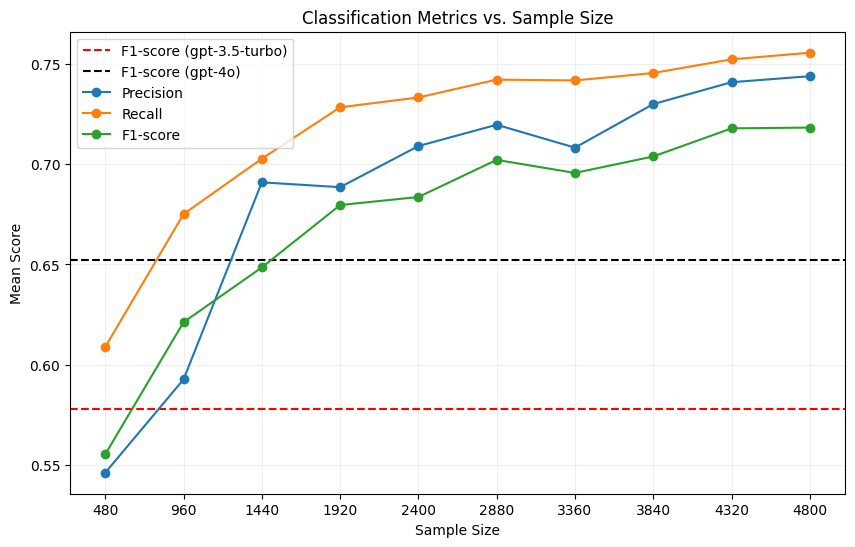

In [17]:
# Extract sample sizes and metrics
sample_sizes = mean_results_df["Sample Size"].tolist()
precision_means = mean_results_df["Mean Precision"].tolist()
recall_means = mean_results_df["Mean Recall"].tolist()
f1_means = mean_results_df["Mean F1-Score"].tolist()

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.axhline(y=gpt_3_5_turbo_f1, color='red', linestyle='--', label="F1-score (gpt-3.5-turbo)")  # prompt3
plt.axhline(y=gpt_4o_f1, color='black', linestyle='--', label="F1-score (gpt-4o)")  # prompt3

# Convert sample size id to sample size num
plt.plot(sample_sizes, precision_means,  marker= 'o', label='Precision')
plt.plot(sample_sizes, recall_means, marker= 'o', label='Recall')
plt.plot(sample_sizes, f1_means, marker= 'o', label='F1-score')
plt.xticks(sample_sizes)
plt.xlabel('Sample Size')
plt.ylabel('Mean Score')
plt.title('Classification Metrics vs. Sample Size')
plt.legend()
plt.grid(True, alpha=0.2)  # Improved grid visibility
plt.show()

# Compare on Agreement - WIP

In [18]:
import os
import pandas as pd
import ast

folder_path = "/home/fantoni/patent-sentence-classification/results/incremental"
id2num = {'1': 480, '2': 960, '3': 1440, '4': 1920, '5': 2400, '6': 2880, '7': 3360, '8': 3840, '9': 4320, '10': 4800}

# Import agreement data
agreement_df = pd.read_excel("/home/fantoni/patent-sentence-classification/data/1200_agreement_All.xlsx", usecols=['sent_id', 'agreement'])

# Process all files
results_all = []
for file_name in os.listdir(folder_path):
    if file_name.endswith(".xlsx"):
        sample_id = file_name.split('_')[1]
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)

        # Merge with agreement data
        df = pd.merge(df, agreement_df, on='sent_id', how='left')

        # Compute correct predictions
        df['correct'] = df['sent_class'] == df['predicted_class']
        
        # Extract max probabilities
        df["probabilities"] = df["probabilities"].apply(ast.literal_eval) # import as a list
        df['max_prob'] = df['probabilities'].apply(max)
        
        # Collect data 
        data = {
            'Sample Size': id2num[sample_id],
            'max_prob': df['max_prob'].tolist(),
            'agreement': df['agreement'].tolist(),
            'correct': df['correct'].tolist()
        }

        results_all.append(data)

# Convert and explode DataFrame
results_df = pd.DataFrame(results_all).sort_values(by='Sample Size')
results_df = results_df.explode(['max_prob', 'agreement', 'correct']).reset_index(drop=True)
results_df

,Sample Size,max_prob,agreement,correct
0,480,0.5,False,False
1,480,0.61,True,True
2,480,0.49,False,True
3,480,0.53,True,True
4,480,0.38,True,True
...,...,...,...,...
119995,4800,0.65,False,False
119996,4800,0.73,True,True
119997,4800,0.94,True,True
119998,4800,0.88,False,True


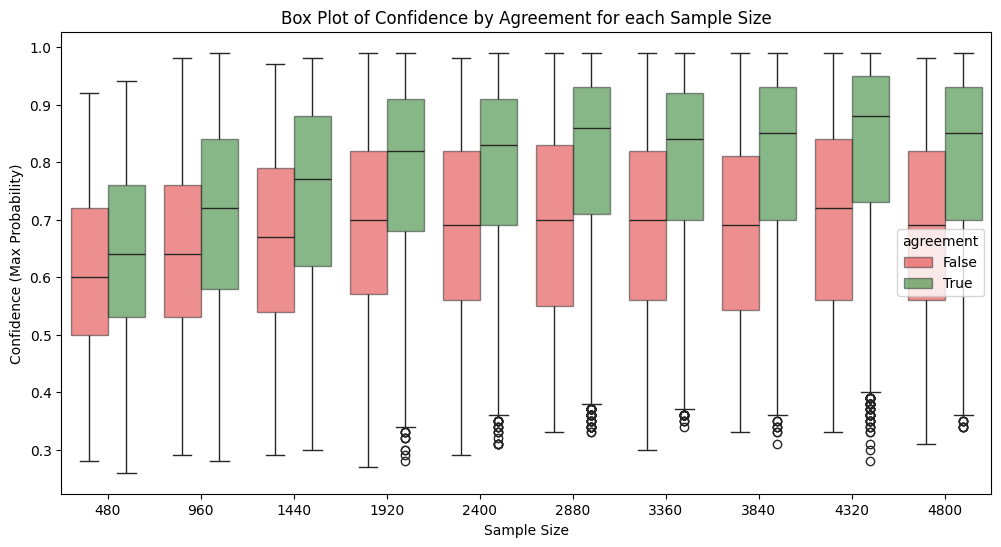

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot for 'max_prob' by 'agreement', grouped by 'Sample Size'
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df,
    x='Sample Size',
    y='max_prob',
    hue='agreement',
    palette={True: 'green', False: 'red'},
    boxprops=dict(alpha=0.5))
    
plt.xlabel("Sample Size")
plt.ylabel("Confidence (Max Probability)")
plt.title("Box Plot of Confidence by Agreement for each Sample Size")
plt.show()

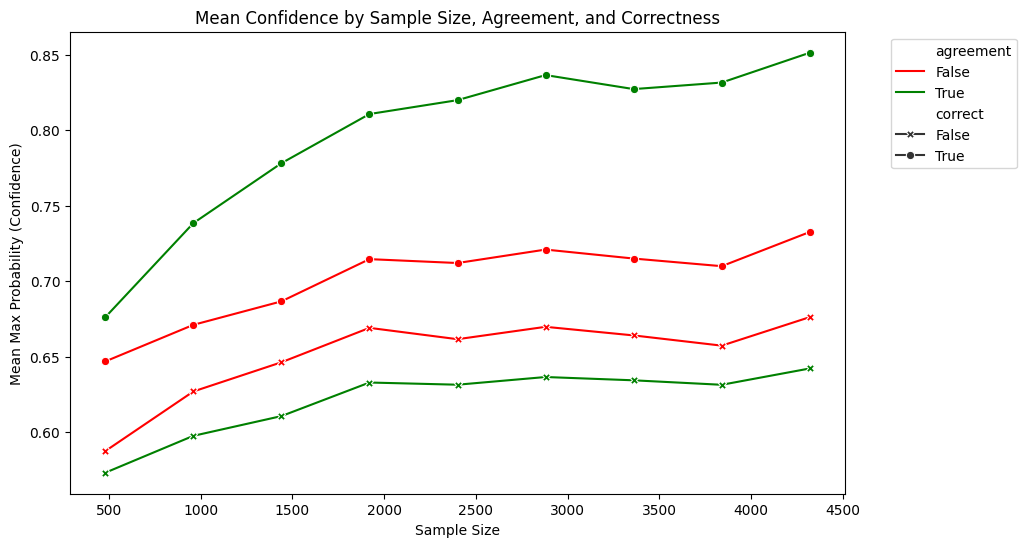

In [86]:
# Compute mean max_prob grouped by 'Sample Size' and 'Agreement' and 'Correct'
mean_df = exploded_df.groupby(['Sample Size', 'agreement', 'correct'])['max_prob'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=mean_df,
    x="Sample Size",
    y="max_prob",
    hue="agreement",
    style="correct",
    markers={True: "o", False: "X"},  # Marker style for 'correct'
    dashes=False,  # Use solid lines
    palette={True: "green", False: "red"}  # Color mapping
)

plt.xlabel("Sample Size")
plt.ylabel("Mean Max Probability (Confidence)")
plt.title("Mean Confidence by Sample Size, Agreement, and Correctness")
plt.legend(title="", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()